<a href="https://colab.research.google.com/github/Clamepending/KamaroAutonomousRCcar/blob/AddPastLayers/RGBtoDepth_AddpastLayers_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.layers import UpSampling2D
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import scipy.ndimage
import cv2
import random
import pickle
import glob
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape, Add
from tensorflow.keras.layers import Conv2DTranspose, DepthwiseConv2D, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import TensorBoard

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
import IPython
from six.moves import urllib

print(tf.__version__)

Mounted at /content/drive
2.5.0


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.version)

Found GPU at: /device:GPU:0
<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [ ]:
pickle_in = open("/content/drive/MyDrive/RGB_and_Depth_Data/PickleData/x_train.pickle", "rb")
x_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/MyDrive/RGB_and_Depth_Data/PickleData/y_train.pickle", "rb")
y_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/MyDrive/RGB_and_Depth_Data/PickleData/x_test.pickle", "rb")
x_test = pickle.load(pickle_in)

pickle_in = open("/content/drive/MyDrive/RGB_and_Depth_Data/PickleData/y_test.pickle", "rb")
y_test = pickle.load(pickle_in)

(2925, 90, 160, 3)


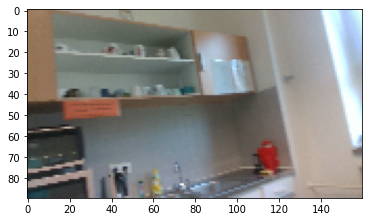

In [ ]:
plt.imshow(x_test[4])
print(x_train.shape)

In [ ]:
#Build the model
dropout = 0.2

input = tf.keras.Input(shape=x_train[0].shape)
pool1 = Conv2D(32, (5, 5), padding='same', activation='relu')(input)
pool1 = MaxPooling2D(pool_size=(2,2))(pool1)
pool1 = Conv2D(48, (4, 4), padding='same', activation='relu')(pool1)
pool1 = MaxPooling2D(pool_size=(1,2))(pool1)

pool1 = Conv2D(96, kernel_size=(5, 5), activation='relu', padding='same')(pool1)
pool1 = Dropout(dropout)(pool1)
pool1 = MaxPooling2D(pool_size=(3, 2))(pool1)


pool2 = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same')(pool1)
pool2 = Dropout(dropout)(pool2)
pool2 = MaxPooling2D(pool_size=(1, 2))(pool2)

pool3 = Conv2D(384, (3, 3), activation='relu', padding='same')(pool2)
pool3 = Dropout(dropout)(pool3)
pool3 = Conv2D(384, (3, 3), activation='relu', padding='same')(pool3)
pool3 = Dropout(dropout)(pool3)
pool3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
pool3= Dropout(dropout)(pool3)
pool3 = MaxPooling2D(pool_size=(3, 2))(pool3)


pool4 = Conv2D(4096, (3, 3), activation='relu', padding="same")(pool3)
pool4 = Dropout(dropout)(pool4)
pool4 = Conv2D(4096, (3, 3), activation='relu', padding="same")(pool4)
pool4 = Dropout(dropout)(pool4)
pool4 = Conv2D(21, (3, 3), activation='relu', padding="same")(pool4)
pool4 = Dropout(dropout)(pool4)


# model.add(UpSampling2D(size=(45, 32)))
# model.add(Conv2D(21, (5, 5), activation='relu', padding="same"))
pool1 = Dense(1, activation='relu')(pool1)
pool2 = Dense(1, activation='relu')(pool2)
pool3 = Dense(1, activation='relu')(pool3)
pool4 = Dense(1, activation='relu')(pool4)

print(pool1.shape)
firstAdd = Add()([pool3, pool4])

pool3Upsample = UpSampling2D(size=(3, 2))(firstAdd)
secondAdd = Add()([pool2, pool3Upsample])

pool2Upsample = UpSampling2D(size=(1, 2))(secondAdd)
thirdAdd = Add()([pool1, pool2Upsample])

modeloutput = UpSampling2D(size=(6, 8))(thirdAdd)

print(modeloutput.shape)


model = tf.keras.models.Model(inputs=input, outputs=modeloutput)

model.summary()

(None, 15, 20, 1)
(None, 90, 160, 1)
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           [(None, 90, 160, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_356 (Conv2D)             (None, 90, 160, 32)  2432        input_38[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_181 (MaxPooling2D (None, 45, 80, 32)   0           conv2d_356[0][0]                 
__________________________________________________________________________________________________
conv2d_357 (Conv2D)             (None, 45, 80, 48)   24624       max_pooling2d_181[0][0]          
_______________________________________________________

In [ ]:
NAME = "depth-cnn-output-dense-" + str(time.time())
tensorboard = TensorBoard(log_dir="/content/drive/MyDrive/RGB_and_Depth_Data/logs/" + NAME)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(x_train, y_train, epochs=200, callbacks=[tensorboard])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/200


ResourceExhaustedError: ignored

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(3,4,1)
plt.imshow(x_test[10])
plt.subplot(3,4,5)
plt.imshow(y_test[10])
plt.subplot(3,4,9)
plt.imshow(model.predict(x_test)[10,:, :, 0])

plt.subplot(3,4,2)
plt.imshow(x_test[20])
plt.subplot(3,4,6)
plt.imshow(y_test[20])
plt.subplot(3,4,10)
plt.imshow(model.predict(x_test)[20,:, :, 0])

plt.subplot(3,4,3)
plt.imshow(x_test[40])
plt.subplot(3,4,7)
plt.imshow(y_test[40])
plt.subplot(3,4,11)
plt.imshow(model.predict(x_test)[40,:, :, 0])

plt.subplot(3,4,4)
plt.imshow(x_test[50])
plt.subplot(3,4,8)
plt.imshow(y_test[50])
plt.subplot(3,4,12)
plt.imshow(model.predict(x_test)[50,:, :, 0])

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [ ]:
plt.figure(figsize=(20,8))
plt.subplot(3,4,1)
plt.imshow(x_train[10])
plt.subplot(3,4,5)
plt.imshow(y_train[10])
plt.subplot(3,4,9)
plt.imshow(model.predict(x_train)[10,:, :, 0])

plt.subplot(3,4,2)
plt.imshow(x_train[20])
plt.subplot(3,4,6)
plt.imshow(y_train[20])
plt.subplot(3,4,10)
plt.imshow(model.predict(x_train)[20,:, :, 0])

plt.subplot(3,4,3)
plt.imshow(x_train[40])
plt.subplot(3,4,7)
plt.imshow(y_train[40])
plt.subplot(3,4,11)
plt.imshow(model.predict(x_train)[40,:, :, 0])

plt.subplot(3,4,4)
plt.imshow(x_train[50])
plt.subplot(3,4,8)
plt.imshow(y_train[50])
plt.subplot(3,4,12)
plt.imshow(model.predict(x_train)[50,:, :, 0])
